# Global constants

In [344]:
GRAIN_TYPE = 'WheatAdded_Type'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
#GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_1/model_Moisture_Content/' + GRAIN_TYPE + '_t1_dnn_mc.h5'

In [345]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np
import random

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)



2.4.1


In [346]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Helper functions

In [347]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(trueValues, predictions)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [348]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/WheatAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# 2. Overview of data


In [349]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,402.500000,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187,16.189541,-0.377074,77.159677,215.799030
std,232.816451,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739,0.629743,6.071761,32.552200,124.108325
min,0.000000,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000,15.352809,-17.418676,22.000000,40.011500
25%,201.250000,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000,15.855506,-5.077754,52.800000,107.817375
50%,402.500000,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500,16.400366,-0.589378,71.200000,195.600450
75%,603.750000,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000,16.401988,4.300734,100.100000,310.863000
max,805.000000,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000,17.344167,14.827701,160.200000,538.146000


In [350]:
# Dimension of the dataset
df.shape

(806, 15)

In [351]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [352]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    #'Attn', 
                    #'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    #'Density'
            ]]

# df_targets = df[['M%', 'Density']]
df_targets = df[['M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [353]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.2
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [354]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining the model

In [355]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  
  my_model = Sequential([   
    layers.Dense(89, input_shape=(6,), activation='relu', 
                #  kernel_regularizer=regularizers.l2(0.01)
                 ),
      # layers.BatchNormalization(),  # Batch normalization layer
      # layers.Dropout(0.2),

      layers.Dense(89, activation='relu', 
                  #  kernel_regularizer=regularizers.l2(0.01)
                   ),

      layers.Dense(89, activation='relu', 
                  #  kernel_regularizer=regularizers.l2(0.01)
                   ),
      
      # layers.BatchNormalization(),  # Batch normalization layer
      # layers.Dropout(0.5),
      
      layers.Dense(1, activation='sigmoid')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.0009) # 0.00051 for good density results
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 89)                623       
_________________________________________________________________
dense_149 (Dense)            (None, 89)                8010      
_________________________________________________________________
dense_150 (Dense)            (None, 89)                8010      
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 90        
Total params: 16,733
Trainable params: 16,733
Non-trainable params: 0
_________________________________________________________________


## Running model with KCV

In [356]:
from sklearn.model_selection import KFold
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

NUM_EPOCHS = 172 # 121 for good density results
BATCH_SIZE = 8
K_FOLD_SPLITS = 10
FILENAME_BEST_MODEL = 'best_model.h5'

# Define the cross-validation process
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y = y_train_norm[:,0]
X = X_train_norm

def train_and_evaluate_fold(train_indices, test_indices):
    trainX, testX = X[train_indices], X[test_indices]
    trainY, testY = Y[train_indices], Y[test_indices]
    
    # Define your model building function and compile it
    model = my_model()
    
    # Fit the model
    history = model.fit(trainX, trainY, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(testX, testY))
    
    # Evaluate the model
    loss, rmse = model.evaluate(x=testX, y=testY, verbose=1)
    
    return loss, rmse, model, history

# Use ThreadPoolExecutor to parallelize the training and evaluation
with ThreadPoolExecutor(max_workers=5) as executor:
    # Submit tasks to the executor
    futures = {executor.submit(train_and_evaluate_fold, train_indices, test_indices): (train_indices, test_indices) for train_indices, test_indices in cv.split(X)}
    
    min_loss = float('inf')
    best_model = None
    history_best_model = None
    arr_loss = []
    
    for future in as_completed(futures):
        loss, rmse, model, history = future.result()
        
        #print(f"Loss = {loss}, RMSE = {rmse}")
        
        arr_loss.append(loss)
        if loss < min_loss:
            best_model = model
            history_best_model = history
            min_loss = loss
    
    #print('Loss array:', arr_loss)

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)


Epoch 1/170
Epoch 1/170
Epoch 1/170
Epoch 1/170
Epoch 1/170
62/62 [==============================] - 1s 6ms/step - loss: 0.0499 - accuracy: 0.0944 - val_loss: 0.0053 - val_accuracy: 0.0545
Epoch 2/170
Epoch 2/170
62/62 [==============================] - 1s 6ms/step - loss: 0.0397 - accuracy: 0.0776 - val_loss: 0.0057 - val_accuracy: 0.1455
Epoch 2/170
62/62 [==============================] - 1s 7ms/step - loss: 0.0509 - accuracy: 0.0896 - val_loss: 0.0081 - val_accuracy: 0.0727
Epoch 2/170
Epoch 2/170
62/62 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 0.0755 - val_loss: 0.0035 - val_accuracy: 0.0545
Epoch 3/170
62/62 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.0865 - val_loss: 0.0029 - val_accuracy: 0.1455
Epoch 3/170
Epoch 3/170
62/62 [==============================] - 0s 3ms/step - loss: 0.0066 - accuracy: 0.0903 - val_loss: 0.0044 - val_accuracy: 0.0727
Epoch 3/170
62/62 [==============================] - 0s 3ms/step - los

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [357]:
print(list(history_best_model.history.keys()))

['loss', 'accuracy', 'val_loss', 'val_accuracy']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


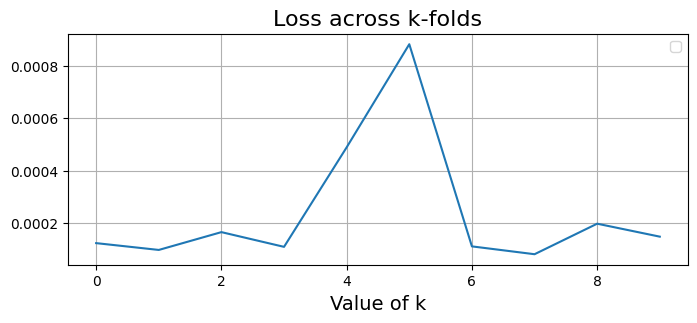

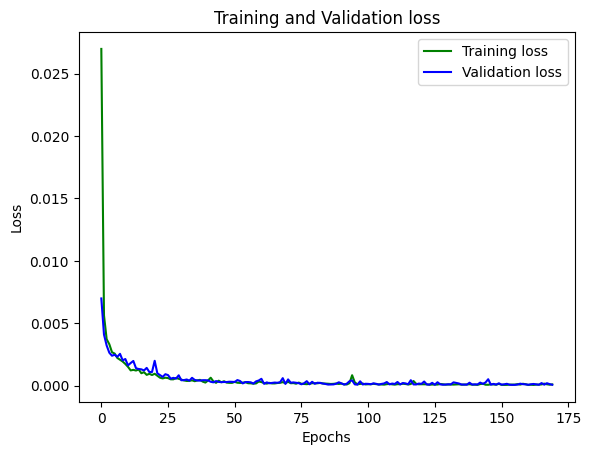

In [358]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

## Prediction on Test Dataset

In [359]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

In [360]:
import time

start_time = time.time()
pred_mc = best_model.predict(X_test_norm)
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")

Y_pred = scaler_output.inverse_transform(pred_mc)
Y_actual = np.array(y_test)

Elapsed time: 0.0248 seconds


## Plotting Real vs Predicted values

Maxval here is:  24.41


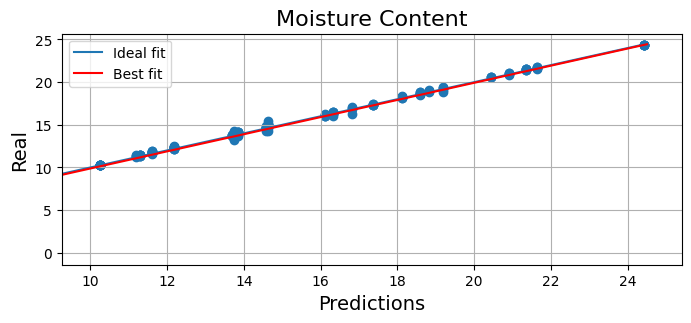

In [361]:
# MOISTURE CONTENT
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
plt.xlim([min(min(Y_pred[:,0]), min(Y_actual[:,0]))-1, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+1])

a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()

plt.savefig('../Poster/Results/obj_1_MC.svg',
                bbox_inches='tight',
                dpi=300, 
                transparent=True)           

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [362]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9975
Mean Squared Error:  0.03545
Mean Absolute Error:  0.1424
Min Absolute Error:  0.000263214111328125
Max Absolute Error:  0.7668286514282219
